<strong>Date :</strong> Créé le 07 Avril 2021| Mis à jour le 11 Avril 2021 </strong>

<strong>Compétition Kaggle - Team Théo
    
@auteur : </strong>Théo SACCAREAU & Théo VEDIS

<strong>(3)_predictive_model
      
Description :</strong> Après avoir mis au point une trentaine de features, notre objectif est de mettre au point un modèle de prédiction des scores. 

Temps d'exécution du Notebook : environ  5min (entre 1 et 2 heures si l'optimisation des paramètres est effectuée).

# Importation des librairies




In [1]:
# Librairies usuelles 
import pandas as pd
import numpy as np
from tqdm import tqdm 
import json
import matplotlib.pyplot as plt


# Libraries pour les modèles de prédiction 
# 1ere partie - Classification 
from sklearn.linear_model import LogisticRegression
from lightgbm import LGBMClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn import tree

# 2e partie - Régression 
from lightgbm import LGBMRegressor

# Validation croisée 
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict

# Optimisaton des hyper-paramètres 
from sklearn.model_selection import ParameterGrid
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV

# Chemin 

In [2]:
# Chemin relatif vers le dossier "data" (inutile de le changer).
pathFile = "../data/" 

# Chargement des données d'entrée

In [6]:
# Ouverture du fichier contenant l'ensemble des features 
# Temps exécution : 2min
with open( pathFile + 'df_features.json') as json_data:
    data_dict = json.load(json_data)

# On transforme le dictionnaire en DataFrame 
# Temps exécution : 1min
df = pd.DataFrame(data_dict)

# On libère de la RAM en supprimant la variable data_dict qui ne nous servira plus
del data_dict 

In [7]:
# On conserve le nom des commentaires dans une variable (pour la soumission) et
# on la supprime du dataframe (ce n'est pas une feature)
name = df['name']
df = df.drop(columns=['name'])

In [8]:
df.head()

,ups,is_parent_comment,is_author_deleted,is_body_deleted,bot_comment,length_comment_chars_before_NLP,length_comment_chars_after_NLP,length_comment_words,nb_stopwords,sentiment,sentiment_child,depth,nb_direct_resp,nb_total_resp,author_centrality_degree,author_centrality_ev,author_prestige_degree,hour,resp_time_parent,resp_time_topic,score_parent,score_topic,nb_comments_parent,nb_comments_topic,ratio_topic,author_mean_score,isSameAuthor,year_creation_author,has_verified_email,comment_karma
0,3.0,1,0,0,0,119,59,8,14,neg,0,2,0,0,0.000138,1.312352e-03,0.000072,night,NaN,22894,NaN,817,1,322,0.86,18.702703,False,2013.0,True,181760.0
1,3.0,0,0,0,0,48,13,2,7,neg,0,2,0,0,0.000005,2.167334e-19,0.000000,night,13205.0,13205,10800.0,10800,1443,1443,0.86,1.750000,False,2012.0,True,23937.0
2,5.0,1,0,0,0,4,4,1,0,neu,0,2,0,0,0.000126,1.712427e-03,0.000051,night,NaN,20339,NaN,3268,5,1610,0.82,3.105263,False,2013.0,True,125197.0
3,1.0,1,0,0,0,54,15,3,12,neg,0,2,0,0,0.000000,2.167334e-19,0.000000,night,NaN,109679,NaN,13643,4,22,0.82,1.000000,False,2013.0,True,7663.0
4,101.0,1,0,0,0,241,164,24,20,pos,0,2,1,2,0.000004,5.092290e-05,0.000002,night,NaN,22895,NaN,817,2,322,0.86,51.500000,False,2013.0,True,5344.0


# Ultime nettoyage
Avant que notre DataFrame contenant les features soient totalement prêt, il reste deux étapes à effectuer : 
- la correction des valeurs nulles pour certaines features (certains algorithmes de Machine Learning ne savent pas comment traiter ces valeurs et échoueront)
- la conversion des features qualitative. En effet, la bibliothèque "Scklearn" ne prend pas en charge les variables nominales. Il faut donc les transformer en variables quantitatives binaires (si deux modalités) ou n-aires grâce à la commande "get_dummies".

In [9]:
# On vérifie quelles variables ont des valeurs nulles.
df.isnull().sum()

ups                                1016458
is_parent_comment                        0
is_author_deleted                        0
is_body_deleted                          0
bot_comment                              0
length_comment_chars_before_NLP          0
length_comment_chars_after_NLP           0
length_comment_words                     0
nb_stopwords                             0
sentiment                                0
sentiment_child                          0
depth                                    0
nb_direct_resp                           0
nb_total_resp                            0
author_centrality_degree                 0
author_centrality_ev                     0
author_prestige_degree                   0
hour                                     0
resp_time_parent                     22566
resp_time_topic                          0
score_parent                        605525
score_topic                              0
nb_comments_parent                       0
nb_comments

Il y a donc 6 variables qui contiennent des valeurs nulles (`ups` exclue). Il y a plusieurs façons de procéder pour remplacer ces valeurs nulles : remplacer par 0, remplacer par la médiane, remplacer par la moyenne, remplacer par la valeur la plus fréquente etc. <br>
- Pour `resp_time_parent`, nous avons fait le choix de remplacer les valeurs manquantes par la moyenne. C'est la solution qui nous paraissait la plus naturelle car elle permet de ne pas discriminer positivement ou négativement les commentaires n'ayant pas ce type d'informations.  
- Pour `score_parent`, nous n'avons pas choisi d'utiliser la moyenne tout simplement parce une très grande majorité des scores de parents est de 1 mais la moyenne vaut plus de 1000 (car il y a quelques rares commentaires parents qui ont un score extrêment élevé). Ainsi, nous estimons qu'il est mieux de donner comme score le score le plus fréquent (1) plutôt que la moyenne qui est dopée par des commentaires extrêmes (1073). 
- Pour `author_mean_score` et `comment_karma`, même raisonnement que pour `score_parent`. 
- Enfin, pour `year_creation_author` et `has_verified_email`, ce sont deux variables avec modalités, il faut donc clairement utiliser la valeur la plus fréquente. 

In [10]:
# On calcule les valeurs de remplacement
mean_resp_time = df['resp_time_parent'].mean()
freq_score_parent = df['score_parent'].value_counts().index[0]
freq_score_author = df['author_mean_score'].value_counts().index[0]
freq_karma = df['comment_karma'].value_counts().index[0]
freq_year = df['year_creation_author'].value_counts().index[0]
freq_email = df['has_verified_email'].value_counts().index[0]

# Puis on remplace les valeurs nulles par les valeurs calculées au-dessus
df['resp_time_parent'] = df['resp_time_parent'].fillna(mean_resp_time)
df['score_parent'] = df['score_parent'].fillna(freq_score_parent)
df['author_mean_score'] = df['author_mean_score'].fillna(freq_score_author)
df['comment_karma'] = df['comment_karma'].fillna(freq_karma)
df['year_creation_author'] = df['year_creation_author'].fillna(freq_year)
df['has_verified_email'] = df['has_verified_email'].fillna(freq_email)

In [11]:
# Vérification
df.isnull().sum()

ups                                1016458
is_parent_comment                        0
is_author_deleted                        0
is_body_deleted                          0
bot_comment                              0
length_comment_chars_before_NLP          0
length_comment_chars_after_NLP           0
length_comment_words                     0
nb_stopwords                             0
sentiment                                0
sentiment_child                          0
depth                                    0
nb_direct_resp                           0
nb_total_resp                            0
author_centrality_degree                 0
author_centrality_ev                     0
author_prestige_degree                   0
hour                                     0
resp_time_parent                         0
resp_time_topic                          0
score_parent                             0
score_topic                              0
nb_comments_parent                       0
nb_comments

Il n'y a plus de variables avec des valeurs nulles (hormis `ups`). 

Passons à la vérification des types de données. 


In [12]:
# Informations sur les types des variables
print(df.info())

<class 'pandas.core.frame.DataFrame'>
Index: 4234970 entries, 0 to 4234969
Data columns (total 30 columns):
 #   Column                           Dtype  
---  ------                           -----  
 0   ups                              float64
 1   is_parent_comment                int64  
 2   is_author_deleted                int64  
 3   is_body_deleted                  int64  
 4   bot_comment                      int64  
 5   length_comment_chars_before_NLP  int64  
 6   length_comment_chars_after_NLP   int64  
 7   length_comment_words             int64  
 8   nb_stopwords                     int64  
 9   sentiment                        object 
 10  sentiment_child                  int64  
 11  depth                            int64  
 12  nb_direct_resp                   int64  
 13  nb_total_resp                    int64  
 14  author_centrality_degree         float64
 15  author_centrality_ev             float64
 16  author_prestige_degree           float64
 17  hour         

Quaatre variables ne sont pas de types quantitatives : `sentiment`, `hour` (de type `str`), `has_verified_email` et `isSameAuthor` (de type `boolean`). <br>  Pour ces deux dernières il suffit de remplacer `True` par 1 et `False` par 0. <br>
Pour les variables nominales, nous utiliserons la fonction `get_dummies`.  Cette commande élimine les variables nominales en créant de nouvelles colonnes. Ces nouvelles colonnes portent le nom de la modalité de la variable nominale (exemple : 'sentiment_neg' pour sentiment négatif) et leur valeur vaut 0 (le commentaire n'avait pas cette modalité) ou 1 (le commentaire avait cette modalité). Ainsi de suite pour les 4 autres modalités. 

In [13]:
# Transformation des variables de type 'booléen' en variables quantitatives
df['isSameAuthor'] = df['isSameAuthor'].apply(lambda x : 1 if x else 0)
df['has_verified_email'] = df['has_verified_email'].apply(lambda x : 1 if x else 0)

In [14]:
# Transformation des variables nominales en variables quantitatives
df = pd.get_dummies(df)

In [15]:
# Vérification 
print(df.info())

<class 'pandas.core.frame.DataFrame'>
Index: 4234970 entries, 0 to 4234969
Data columns (total 35 columns):
 #   Column                           Dtype  
---  ------                           -----  
 0   ups                              float64
 1   is_parent_comment                int64  
 2   is_author_deleted                int64  
 3   is_body_deleted                  int64  
 4   bot_comment                      int64  
 5   length_comment_chars_before_NLP  int64  
 6   length_comment_chars_after_NLP   int64  
 7   length_comment_words             int64  
 8   nb_stopwords                     int64  
 9   sentiment_child                  int64  
 10  depth                            int64  
 11  nb_direct_resp                   int64  
 12  nb_total_resp                    int64  
 13  author_centrality_degree         float64
 14  author_centrality_ev             float64
 15  author_prestige_degree           float64
 16  resp_time_parent                 float64
 17  resp_time_top

Enfin, on convertit les colonnes qui étaient en `float` (à cause des `np.nan`) en `int`. 

In [16]:
# Liste des colonnes à convertir en int
columns_to_int = ['resp_time_parent', 'score_parent', 'comment_karma', 
                  'year_creation_author', 'has_verified_email'] 
                  # Pas de author_mean_score car les valeurs peuvent être décimales

for col in tqdm(columns_to_int) : 
    df[col] = df[col].apply(lambda x : int(x))

100%|██████████| 5/5 [00:10<00:00,  2.08s/it]


In [17]:
# Dernière vérification 
print(df.info())

<class 'pandas.core.frame.DataFrame'>
Index: 4234970 entries, 0 to 4234969
Data columns (total 35 columns):
 #   Column                           Dtype  
---  ------                           -----  
 0   ups                              float64
 1   is_parent_comment                int64  
 2   is_author_deleted                int64  
 3   is_body_deleted                  int64  
 4   bot_comment                      int64  
 5   length_comment_chars_before_NLP  int64  
 6   length_comment_chars_after_NLP   int64  
 7   length_comment_words             int64  
 8   nb_stopwords                     int64  
 9   sentiment_child                  int64  
 10  depth                            int64  
 11  nb_direct_resp                   int64  
 12  nb_total_resp                    int64  
 13  author_centrality_degree         float64
 14  author_centrality_ev             float64
 15  author_prestige_degree           float64
 16  resp_time_parent                 int64  
 17  resp_time_top

Remarque : Le type `int64` correspond à des entiers signés sur 64 bits et le type `uint8`à des entiers non-signés sur 8 bits. 

# Séparation train-test
Désormais que notre DataFrame est prêt à l'emploi, on le sépare en deux : une partie sera dédié à l'apprentissage ('train') et l'autre à l'évaluation des prédictions ('test'). 

In [18]:
# Comme imposé par l'énoncé, le découpage se fait selon les valeurs de 'ups'.
df_train = df.loc[np.isnan(df['ups']) == False]
df_test = df.loc[np.isnan(df['ups'])]

# On vérifie que le découpage ne laissent aucun commentaire sur le côté
print(df.shape[0] == (df_train.shape[0] + df_test.shape[0]))

True


In [19]:
print("TRAIN DATA: \nNombre de lignes: %i (%.f%%) "\
      %(df_train.shape[0], df_train.shape[0]/df.shape[0]*100))

print("\nTEST DATA: \nNombre de lignes: %i (%.f%%) "\
      %(df_test.shape[0], df_test.shape[0]/df.shape[0]*100))


TRAIN DATA: 
Nombre de lignes: 3218512 (76%) 

TEST DATA: 
Nombre de lignes: 1016458 (24%) 


L'échantillon de train représente plus de 75% des données. 






Comme on va réaliser un apprentissage supervisé, on doit séparer l'ensemble 'train' en deux parties : une partie contenant les features (Xtrain) et l'autre contenant la variable à prédire (Ytrain, ici le score). 

In [20]:
# Séparation features / variable à prédire 

Xtrain = df_train.iloc[:, 1:]
Ytrain = pd.Series(df_train.iloc[:, 0], dtype=int)
Xtest = df_test.iloc[:, 1:]

# Modèle de prédiction 
Tout est désormais prêt pour qu'on puisse mettre en place un modèle de prédiction des scores de commentaires. <br>
Pour commencer, regardons la répartition des scores sur l'échnatillon d'apprentissage. 

In [21]:
pd.Series(Ytrain).value_counts()[:10]

 1    1676837
 2     575082
 3     219060
 0     153372
 4      75130
 5      66586
 6      47904
-1      38365
 7      34214
 8      25921
Name: ups, dtype: int64

On constate que plus de 1.67 millions de commentaires ont pour score 1. Cela représente (52% des données d'entrainement).

En faisant cette constatation, nous avons décidé de réaliser un premier modèle de classification avant de créer un modèle de régression. 

## (1) Modèle(s) de classification 
L'objectif de cette première étape est d'essayer de séparer nos commentaires en deux : d'un côté les commentaires avec un score de 1, de l'autre le reste des commentaires. Cela permettrait d'avoir deux groupes plus ou moins de même taille mais surtout nous pensons que le modèle de regréssion appliqué sur le deuxième groupe aura plus de faciliter à prédire car il sera moins "géné" par la forte porportion de 1. 

### 1-1 Séparation des données train 
La première étape est de constitué une nouvelle liste de Ytrain constituée uniquement de 1 (score égal à 1) ou de 0 (score différent de 1). 

In [22]:
def partition(y):
    """
    Fonction qui permet de transformer Ytrain (variable continue) en variable 
    binaire composée de 0 ou de 1. 

    Paramètre : 
        - y (int) : score du commentaire initial.
    
    Sortie : 
        - y (int) : deux valeurs possibles : 1 si le paramètre d'entrée 
        valait 1, 0 sinon. 
    """

    if (y == 1):
        y = 1
    
    else :
        y = 0
    
    return y

In [23]:
Ytrain_classif = [partition(y) for y in Ytrain]
pd.Series(Ytrain_classif).value_counts()

1    1676837
0    1541675
dtype: int64

Comme évoqué au-dessus, le fait d'appliquer cette classification sur Ytrain, permet d'obtenir (en théorie), deux groupes homogènes. 

L'objectif est désormais de trouver un modèle de classification qui permettent de séparer les données de test de cette façon. 

### 1-2 Choix du modèle de classification 
La première étape est bien évidemment de choisir le meilleur modèle de classification. 

Pour cela, nous avons pré-sélectionné 4 modèles de classification : `KNeighbors`, `LightGBM`, `DecisionTree` et `LogisticRegression`. Cette sélection s'est fait à partir de nos expériences passées et nous avaons fait en sorte d'utiliser plusieurs types d'algorithmes : linéaire (régression logistique), descente de gradient (LightGBM), plus proches voisins (KNeighbors) et arbre de décision (DecisionTree). 

Pour pouvoir sélectionner le meilleur modèle, nous devons réaliser une validation croisée sur l'échantion d'apprentissage. Il existe plusieurs types de validation croisée, le plus courant est la méthode "k-folds". Elle consiste à diviser l'échantillon d'apprentissage 'train' en k sous-échantillons, puis à sélectionner un des k sous-échantillions comme l'ensemble de test et les k-1 autres sous-échantillons constituent l'ensemble d'apprentissage. Ensuite, le score de performance (taux de prédiction dans notre cas car nous utilisons des classifieur) est calculé. Cette opération se répète ensuite en sélectionnant un autre sous-échantillon de test parmi les k-1 restant. L'opération se répète ainsi k fois pour qu'en fin de compte chaque sous-échantillon ait été utilisé exactement une fois comme ensemble de test. La mesure de performance rapportée par la validation croisée "k-folds" est alors la moyenne des valeurs calculée dans la boucle. 


In [ ]:
# 4 modèles qu'on souhaite comparer
knn = KNeighborsClassifier(n_neighbors=3)
reglog = LogisticRegression(random_state=1234, max_iter=500)
lgbm = LGBMClassifier(random_state=1234)
tree = tree.DecisionTreeClassifier(random_state=1234)

# Liste qui contiendra la liste des moyennes des taux de prédictions à chaque 
# itération pour chaque modèle. 
scores = []

# Pour chaque modèle on réalise une validation croisée.
for model in tqdm([knn, reglog, lgbm, tree]):
    scores.append(cross_val_score(model, Xtrain, Ytrain_classif, cv=3))

In [ ]:
# On fait la moyenne des scores à chaque itération pour n'avoir qu'un seul
# score par modèle 
scores_moy = [(model, np.mean(score)) for model, score in zip(
    ['KNN', 'RegLog', 'LGBM', 'Tree'], scores)]

On affiche les résultats à l'aide d'un graphique 

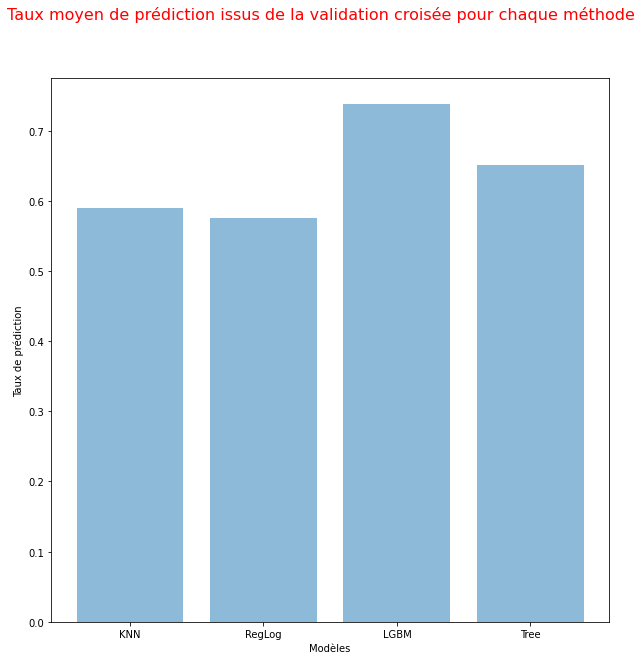

In [ ]:
# On augmente la taille de la figure
plt.figure(figsize=(10,10))

# On y ajoute un titre
plt.suptitle('Taux moyen de prédiction issus de la validation croisée pour chaque méthode', fontsize=16, color='red')

# On affiche le diagramme en barres
plt.bar(range(4),  np.array(np.array(scores_moy)[:,1], dtype=float), align='center', alpha=0.5)

# On ajoute un titre à chaque barre afin de connaitre à quelle méthode elle corrrespond
plt.xticks(range(4), np.array(scores_moy)[:,0])

# On ajoute un titre à chaque axe
plt.xlabel("Modèles")
plt.ylabel("Taux de prédiction")

# On affiche la figure
plt.show()

Le meilleur modèle est donc clairement le LGBMClassifieur. C'est un avantage car c'est l'un des plus rapides. 

Par ailleurs, le taux de prédiction peut sembler assez faible (un peu moins de 75%) mais il ne faut pas oublier que la différence entre le cluster 0 et le cluster 1 est très faible pour les scores proches de 1 (0, 2, 3). En effet, il n'est pas illogique que le classifieur se "trompe" en classant un commentaire avec un score de 2 dans le cluster 1 ou lieu du cluster 0. Cela reste des erreurs "faibles" comparés au fait qu'il classe un commentaire avec un score de 500 dans le cluster 1. 

### 1-3 Application de la classification sur l'échantillon de test 

In [24]:
# Définition du meilleur modèle
lgbm = LGBMClassifier(random_state=123)

# Apprentissage (sur Ytrain_classif)
lgbm.fit(Xtrain, Ytrain_classif)

# Prédiction (sur Xtest)
pred_classif = lgbm.predict(Xtest)

On doit également appliquer cette classification sur l'échantillon d'entrainement (par validation croisée) car pour entrainer le futur modèle de régression sur le groupe 0 (constitué normalement des commentaires ayant un score différent de 1), on doit utiliser un ensemble d'apprentissage plutôt "similaire" : celui qui aura était classé à 0 par validation croisée. 

In [25]:
# Contrairement à la validation croisée précédente, ici le résultat est la 
# prédiction et non pas le taux de prédiction. 
pred_classif_train = cross_val_predict(lgbm, Xtrain, Ytrain_classif, cv=3)

On ajoute les résultats de classification (aussi bien sur Train que sur Test) au DataFrame afin de séparer les échantillons d'apprentissage et de test en deux (un pour le cluster 0 un autre pour le cluster 1). 

In [26]:
# On concatène les deux listes de résultats de clusters 
clusters = list(pred_classif_train) 
clusters.extend(pred_classif)

# On vérifie que la longueur est bien égale au nombre de commentaires au total
len(clusters)

4234970

In [27]:
# On l'ajoute dans une nouvelle colonne du DataFrame
df['cluster'] = clusters

In [28]:
index_train_0 = [str(i) for i in df.loc[np.isnan(df['ups']) == False].loc[df['cluster'] == 0].index]
index_train_1 = [str(i) for i in df.loc[np.isnan(df['ups']) == False].loc[df['cluster'] == 1].index]
index_test_0 = [str(i) for i in df.loc[np.isnan(df['ups'])].loc[df['cluster'] == 0].index]
index_test_1 = [str(i) for i in df.loc[np.isnan(df['ups'])].loc[df['cluster'] == 1].index]

# Vérification 
len(index_train_0) + len(index_train_1) + len(index_test_0) + len(index_test_1)

4234970

Malgré le fait que le clustering n'est pas parfait, une grande majorité des commentaires de l'échantillon 'test' classés dans le groupe "1" sont censés avoir un score de "1" (ou très proche 0, 2). Ainsi au lieu d'appliquer un modèle de régression sur ce groupe de commentaire, on met pour chacun d'eux la prédiction à 1. 


In [29]:
# On crée un dictionnaire qui met en relation l'index du commentaire et son score.
# Ici le score est 1. Le dictionnaire sera mis à jour au fur et à mesure qu'on 
# prédit de nouveau score.
prediction = dict([(index, 1)  for index in index_test_1])

Désormais, nous devons prédire les scores sur l'échantillon de test classé dans le cluster 0 (à partir de données d'entrainement classées également dans le clsuter 0). 

In [30]:
Ytrain.loc[index_train_0].value_counts()[:10]

 1    349091
 2    285728
 3    157997
 0     69727
 4     62719
 5     57436
 6     43039
 7     31438
 8     24122
-1     23690
Name: ups, dtype: int64

On s'aperçoit que malgré notre 1ère étape de classification, le nombre de commentaires ayant un score de "1" est encore majoritaire (bien qu'ils soient bien moins présents). <br> 
Nous avons fait le choix d'effectuer une deuxième étape de classification, cette fois-ci un peu plus large puisque nous souhaitons classe dans le cluster 2 les commentaires classés dans le cluster 0 lors de la première classification et qui ont un score de 1, 2 ou 3 (les scores ayant la plus forte proportion selon la liste précédente). 

### 1-4 2e classification 

In [31]:
def partition2(y):
    """
    Fonction qui permet de transformer Ytrain (variable continue) en variable 
    binaire composée de 0 ou de 2. 

    Paramètre : 
        - y (int) : score du commentaire initial.
    
    Sortie : 
        - y (int) : deux valeurs possibles : 2 si le paramètre d'entrée 
        vaut 1, 2 ou 3, 0 sinon. 
    """

    if (y == 1 or y == 2 or y == 3):
        y = 2

    else :
        y = 0

    return y

In [32]:
Ytrain_classif_2 = [partition2(y) for y in Ytrain.loc[index_train_0]]

In [33]:
pd.Series(Ytrain_classif_2).value_counts()

2    792816
0    603221
dtype: int64

De nouveau, la classification devrait permettre d'obtenir deux groupes de taille plutôt équivalente. 

Appliquons à nouveau le modèle de classification. 

In [34]:
# Définition du meilleur modèle
lgbm = LGBMClassifier(random_state=123)

# Apprentissage (sur Ytrain_classif_2)
lgbm.fit(Xtrain.loc[index_train_0], Ytrain_classif_2)

# Prédiction (sur Xtest classé comme 0 à la première classification)
pred_classif_2 = lgbm.predict(Xtest.loc[index_test_0])

On doit toujours appliquer cette classification sur l'échantillon d'entrainement (par validation croisée).En effet, pour entrainer le futur modèle de régression sur le groupe 0 (constitué normalement des commentaires ayant un score différent de 1, 2 ou 3), on doit utiliser un ensemble d'apprentissage plutôt "similaire" : celui qui aura était classé à 0 lors de la  validation croisée. 

In [35]:
pred_classif_train_2 = cross_val_predict(lgbm, Xtrain.loc[index_train_0], Ytrain_classif_2, cv=3)

On met à jour le numéro de clusters (certains commentaires classés 0 lors de la 1zere classification sont désormais classés 2). 

In [36]:
df.loc[index_train_0, ['cluster']] = pred_classif_train_2
df.loc[index_test_0, ['cluster']] = pred_classif_2

On récupère les nouveaux indexes des clusters 0 et 2 (ceux du cluster 1 restent inchangés).

In [37]:
# Mise à jour des indexes 
index_train_0 = [str(i) for i in df.loc[np.isnan(df['ups']) == False].loc[df['cluster'] == 0].index]
index_train_2 = [str(i) for i in df.loc[np.isnan(df['ups']) == False].loc[df['cluster'] == 2].index]

index_test_0 = [str(i) for i in df.loc[np.isnan(df['ups'])].loc[df['cluster'] == 0].index]
index_test_2 = [str(i) for i in df.loc[np.isnan(df['ups'])].loc[df['cluster'] == 2].index]

# Vérification 
len(index_train_0) + len(index_train_1) + len(index_test_0) + len(index_test_1) + \
len(index_train_2) + len(index_test_2)

4234970

Mettons à jour le dictionnaire de nos prédictions.

 Le groupe 2 est censé contenir une grande majorité de commentaires devant avoir un score de 1, 2 ou 3. Comme précédement, nous jugeons qu'il est plus pertinent de donner à l'ensemble de ces commenataires une seule et même valeur plutôt que d'essayer d'y entrainer un modèle de régression (les résultats des soumissions nous donne raison). 

 Cependant, cette fois-ci, le choix de la valeur est un peu moins évidente que le 1 précédent. Nous avons fait le choix de donner la valeur "2" qui est un bon compromis entre 1 et 3. 

In [38]:
# On ajoute de nouvelles prédictions 
prediction.update(dict([(index, 2)  for index in index_test_2]))

Nous pouvons enfin passer à l'apprentissage d'un modèle de régression sur les données du cluster 0. Ce cluster étant beaucoup plus hétérogène qu'initialement, nous estimons que le modèle de régession aura plus de faciliter à prédire (il ne sera plus gêné par l'abondance de "1"). 

## (2) Modèle de régression
Pour ce modèle de régression nous partons directement sur le modèle LightGBM car c'est l'un des modèles les plus performants (voire le plus performant) dans les compétitions Kaggle. De plus, en faisant des validations croisées sur l'échantillon d'apprentissage c'est lui qui nous offrait les meilleurs performances par rapport aux autres modèles, notamment XGBoost.  

In [39]:
# On ne doit plus que prédire les scores du clusters 0, d'où :
Xtrain0 = Xtrain.loc[index_train_0]
Ytrain0 = Ytrain.loc[index_train_0]
Xtest0 =  Xtest.loc[index_test_0]

### 2-1 Sélection des features les plus pertinentes
L'amélioration de ce modèle peut être fait de deux façons : le tuning des hyperparamètres (c'est-à-dire l'opitmisation des paramètres du modèle) ou la sélection de features. <br> 
Nous commençons ici par la sélection de features. Nous entrainons un modèle sur l'échantillon de train0 et on regarde quelles sont les features les plus importantes. 

In [40]:
# On réalise un premier apprentissage pour déterminer les features avec la plus
# grande importance
LGBM = LGBMRegressor(random_state=12345)
LGBM.fit(Xtrain0, Ytrain0)

LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
              importance_type='split', learning_rate=0.1, max_depth=-1,
              min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
              n_estimators=100, n_jobs=-1, num_leaves=31, objective=None,
              random_state=12345, reg_alpha=0.0, reg_lambda=0.0, silent=True,
              subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

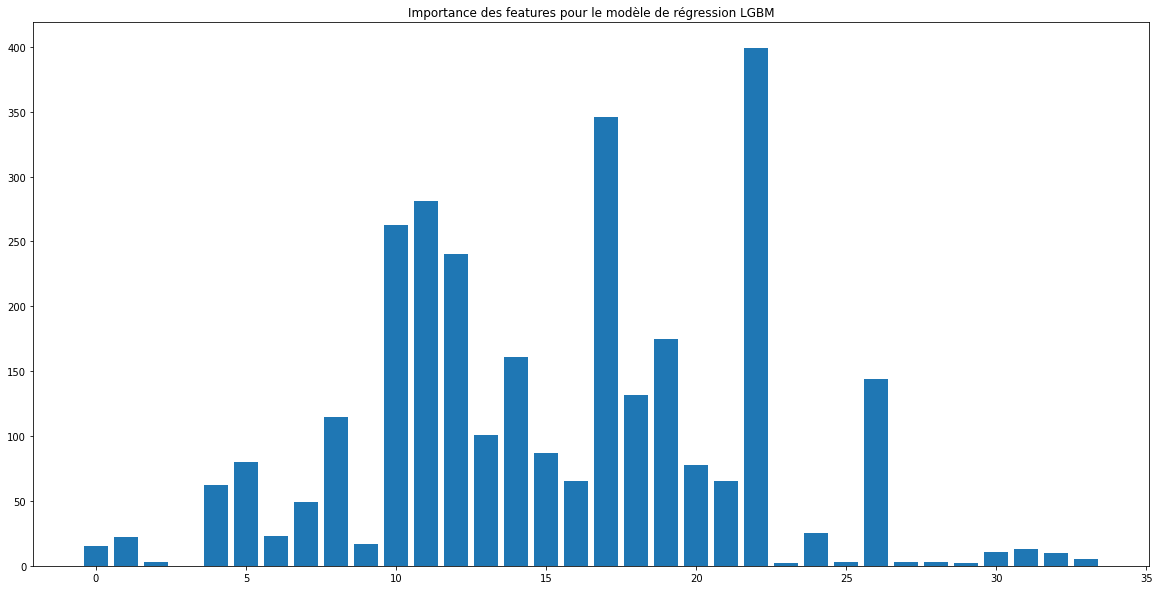

In [41]:
# Taille de la figure 
plt.figure(figsize=(20,10))

# Importance des features
importance = np.abs(LGBM.feature_importances_)

# Noms des features (ici comme il y en a beaucoup on les numérote seulement)
feature_names = np.array(range(0,34))

# Histogramme
plt.bar(height=importance, x=feature_names)

# Titre
plt.title("Importance des features pour le modèle de régression LGBM")

# Affichage
plt.show()

On voit clairement à l'aide de ce graphique qu'il y a des features qui aident à la prédiction (17, 22, etc). Et d'autres pas du tout (4, 34, 35). On ne sait pas à quoi elles correspondent, donc faisons la correspondance entre les numéros et leur nom. 

On récupère les 17 features qui ont un coefficient supérieur à 50. 

In [42]:
indexes_best_features = np.argsort(importance)[::-1][:17]
[(features, index) for index, features in enumerate(Xtest.columns) if index in indexes_best_features]

[('length_comment_chars_before_NLP', 4),
 ('length_comment_chars_after_NLP', 5),
 ('sentiment_child', 8),
 ('nb_direct_resp', 10),
 ('nb_total_resp', 11),
 ('author_centrality_degree', 12),
 ('author_centrality_ev', 13),
 ('author_prestige_degree', 14),
 ('resp_time_parent', 15),
 ('resp_time_topic', 16),
 ('score_parent', 17),
 ('score_topic', 18),
 ('nb_comments_parent', 19),
 ('nb_comments_topic', 20),
 ('ratio_topic', 21),
 ('author_mean_score', 22),
 ('comment_karma', 26)]

Voici la liste des features ayant le plus grand impact sur la régression. Sans surprise on retrouve les features liées au score des éléments autour du commentaire (score du parent, score du topic, score moyen de l'auteur, etc). 

On a "joué" avec cette liste pour obtenir les meilleures prédictions sur l'échantillon de test. Finalement, le nombre de features retenues est de 12. 

In [43]:
# Modification des échantillons d'apprentissage et de test 
indexes_best_features = [4, 5, 8, 10, 11, 15, 16, 18, 19, 20, 22, 26]

Xtest0 = Xtest0.iloc[:, indexes_best_features]
Xtrain0 = Xtrain0.iloc[:, indexes_best_features]

In [44]:
# Apprentissage avec un nombre de features réduit
LGBM = LGBMRegressor(random_state=12345)
LGBM.fit(Xtrain0, Ytrain0)
pred = LGBM.predict(Xtest0)

In [45]:
# Ajout des dernières prédictions
# Le score que l'on prédit doit être un entier donc il faut "caster" la prédiction
prediction.update(dict([(index, int(predic))
                        for index, predic in zip(index_test_0, pred)]))

Après soumission, on constate une amélioration des résultats. 

### 2-2 Optimisation des hyper-paramètres
Tous les algorithmes d'apprentissage sont paramétrables. Les valeurs de ces paramètres peuvent impacter les performances du modèle et sont dépendantes des données manipulées. Il peut alors être intéressant de chercher les meilleures valeurs de ces paramètres pour booster la performance de notre modèle. C'est ce que l'on appelle l'étape d'optimisation des hyper-paramètres. <br> 
Normalement la stratégie à adopter est l'utilisation d'une grille de recherche telle que : 

In [46]:
# On définit des listes de valeurs pour certains paramètres. 
parameters_LGBM = { 
    'num_leaves': np.arange(5, 100, 5),
    'n_estimators ' : np.arange(100, 1000, 100), 
    'subsample_for_bin ' : np.arange(50000, 500000, 50000), 
    'objective ' : ['regression'], 
    'min_child_samples ' : np.arange(10, 500, 50), 
    'min_child_weight': [1e-5, 1e-3, 1e-2, 1e-1, 1, 1e1, 1e2, 1e3, 1e4],
    'importance_type ' : ('split', 'gain'),
    'learning_rate' : [0.5, 0.1, 0.05, 0.01, 0.005, 0.001]
}

In [47]:
# Nombre de combinaison 
len(list(ParameterGrid(parameters_LGBM)))

1662120

Comme le nombre de paramètres à optimiser est important, le nombre de combinaisons possibles explose. Il est bien évidemment impossible de tester chacune des solutions. La solution est de passer par la fonction `RandomizedSearchCV` qui permet de texter aléatoirement `n_iter` combinaison. <br> 
Le problème est que pour tester au moins 10% des solutions possibles, il faudrait tester plus de 150 000 combinaisons et donc entrainer 150 000 fois le modèle. Ce qui serait très très long. <br> 
Nous avons effectué seulement 1000 entrainement, mais le résultat retrouné n'améliorait pas notre modèle (ce qui n'est pas étonant car il aurait fallut beaucoup de chance pour donner sur la bonne combinaison sachant qu'on en tire aléatoirement 1000 parmi 1.6 millions...). C'est une méthode que nous avons donc abandonné. 

In [49]:
classifier = LGBMRegressor(random_state=123, silent=True, metric='l1', n_jobs=-1)

find_parameters = RandomizedSearchCV(
    estimator=classifier, param_distributions=parameters_LGBM, 
    n_iter=1000,
    scoring='neg_mean_absolute_error',
    cv=3,
    random_state=300,
    verbose=False)

# Prend plus d'une heure à être exécuté
#find_parameters.fit(Xtrain0, Ytrain0)

In [ ]:
print('Best score : {} with parameters: {} '.format(find_parameters.best_score_, find_parameters.best_params_))

Pour optimiser les paramètres de notre modèle `LGBMRegressor`, nous avons donc dû procédé manuellement. Pour cela, la [page officiel du LGBM](https://lightgbm.readthedocs.io/en/latest/Parameters-Tuning.html) nous a été d'une aide précieuse. En effet, on y apprant que pour un meilleur score, il est conseillé soit d'augmenter la valeur de `max_bin` (ce qui peut ralentir l'entrainement), soit de diminuer la valeur de `learning_rate` et augmenter celle de `n_estimators`, soit d'augmenter la valeur de `large num_leaves` ou soit d'utiliser le boosting de type `dart` au lieu de `gbdt`. <br> 
Après plusieurs tests, nous avons finalement diminué la valeur de `learning_rate` et augmenté celle de `n_estimators` (nombre d'itérations). 


In [50]:
LGBM = LGBMRegressor(random_state=12345, learning_rate=0.01, n_estimators=500)
LGBM.fit(Xtrain0, Ytrain0)
pred = LGBM.predict(Xtest0)

On peut mettre à jour les prédictions sur le cluster 0. 

In [51]:
# Mise à jour des dernières prédictions (elles seront remplacées pas dupliquées)
# Le score que l'on prédit doit être un entier donc il faut "caster" la prédiction
prediction.update(dict([(index, int(predic))
                        for index, predic in zip(index_test_0, pred)]))

In [52]:
len(prediction)

1016458

### 2-3 Sousmission 
Nous avons prédit l'ensemble des commentaires de l'échantillon de test. On peut désormais regrouper le tout dans un DataFrame que nous stockerons dans un fichier qui servira de sousmission sur le site de Kaggle. 

In [53]:
# Identifiants des commentaires
name_submission = [n[3:] for n in name[3218512:]]
# Prédictions des scores
pred_submission = [prediction[index] for index in df_test.index]

# DataFrame
df_submission = pd.DataFrame({'id' : name_submission, 
                              'predicted' : pred_submission})

# Enregistrement dans un fichier 
df_submission.to_csv(pathFile + 'submission_kaggle.csv', index=False)

# Bilan 
Même si le score nous semble être en deçà de notre travail effectué tout au long de ce projet, nous estimons que nous avons fait de notre mieux dans la recherche de features et surtout sur la recherche d'informations supplémentaires sur les auteurs et les topics/posts (par scraping) <br> 
La partie sur l'analyse du contenu des commentaires aurait toutefois méritée plus de travail, mais limités par le temps, nous n'avons pu effectuer tout ce que nous voulions mettre en place (LDA, similirité entre commentaire et le sujet). Peut-être c'est ce qu'il nous a manqué pour amélioré notre score. 
